<a href="https://colab.research.google.com/github/xKDR/Legal-Notebooks/blob/main/disposal_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sponsored by E2E networks.

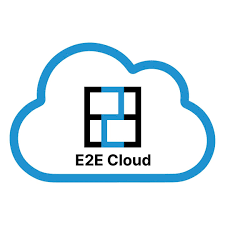

# 2. Setting up the environment

## 2.1 Installing packages

To set up our cloud-based environment, we install the necessary Python packages using the pip command in Google Colab. Below is the code snippet used for installation:

In [69]:
%%capture

# Package for running LLMs locally
!pip install langchain==0.3
!pip install langchain-core==0.3
!pip install langchain-community==0.3

# Package for reading PDF files
!pip install pdfplumber==0.11
!pip install pytesseract==0.3
!pip install pdf2image==1.17

# Machine learning packages
!pip install scikit-learn==1.5
!pip install nltk==3.8
!pip install lightgbm==4.5

# Other helpful libraries
!pip install tqdm==4.66
!pip install pandas==2.1
!pip install pillow==10.4
!pip install matplotlib==3.7

## 2.2 Import packages

After installing the necessary packages, we import the required libraries into our Python environment.

In [70]:
import sqlite3 as db  # SQLite is a lightweight database library for managing database connections.
import io  # IO module to handle input and output operations.
import pdfplumber  # PDF processing library for extracting text from PDF files.
import pandas as pd  # Pandas is a powerful data manipulation and analysis library.

import pytesseract  # Python wrapper for Google's Tesseract-OCR Engine to perform optical character recognition (OCR).
from pdf2image import convert_from_bytes  # Converts PDF files into images for OCR processing.

import re  # Regular expressions library for string matching and manipulation.

from tqdm import tqdm  # Library for displaying progress bars during iterations.

from langchain_community.llms import Ollama # Library for connecting to Ollama

import matplotlib.pyplot as plt # 3.7.1

## 2.3 Install dependancies

We install additional dependencies required for specific functionalities in our analysis. These include:

**Poppler:** This package provides a collection of utilities for working with PDF documents. It includes tools for converting PDF files to various formats, extracting text from PDFs, and manipulating PDF content.

**Tesseract-OCR:** Tesseract is a powerful optical character recognition (OCR) engine that converts images of text into machine-readable text. It is particularly useful for extracting text from scanned documents or images embedded in PDF files. By installing Tesseract, we enable our program to perform OCR on images when direct text extraction is not feasible.

**PCI Utils** is a collection of utilities for inspecting and managing PCI (Peripheral Component Interconnect) devices in the system. This package provides tools that allow us to query information about the hardware components connected to the PCI bus, such as graphics cards, network interfaces, and other peripherals. It is useful when working with machine learning models that may require GPU acceleration, as it enables us to identify available hardware resources and ensure that the appropriate drivers are installed.

In [71]:
%%capture

# !sudo apt-get install -y poppler-utils
# !sudo apt-get install tesseract-ocr
# !sudo apt install pciutils

import subprocess

# Check if 'poppler-utils' is installed
result = subprocess.run(["dpkg", "-l", "poppler-utils"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("poppler-utils is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "poppler-utils"])
else:
    print("poppler-utils is already installed.")

# Check if 'tesseract-ocr' is installed
result = subprocess.run(["dpkg", "-l", "tesseract-ocr"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("tesseract-ocr is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "tesseract-ocr"])
else:
    print("tesseract-ocr is already installed.")

# Check if 'pciutils' is installed
result = subprocess.run(["dpkg", "-l", "pciutils"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.returncode != 0:
    print("pciutils is not installed. Installing now...")
    subprocess.run(["sudo", "apt-get", "install", "-y", "pciutils"])
else:
    print("pciutils is already installed.")


# 3. Orders database

In [72]:
import os
import subprocess

# Path where the file should be downloaded
file_path = "orders.sqlite"

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    subprocess.run([
        "wget",
        "-O", file_path,
        "https://github.com/xKDR/order_substantive_classification/raw/refs/heads/main/orders.sqlite?download="
    ])
    print("File downloaded.")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


`wget` is used to download the SQLite database from a GitHub repository.  It contains court order PDFs. This database will provides orders as well as their labels.

In [73]:
# @title 3.1 Helper functions to work with the database

# Function to read PDF text from BLOB
def read_pdf_text_from_blob(pdf_blob):
    """
    Reads a PDF from binary data and returns its text content.
    If the PDF text cannot be extracted properly, it falls back to OCR.

    :param pdf_blob: Binary data of the PDF.
    :return: Text content of the PDF.
    """
    text = ''

    if pdf_blob is not None:
        # Create a file-like object from the binary data
        pdf_file_like = io.BytesIO(pdf_blob)

        # First attempt to read using pdfplumber
        try:
            with pdfplumber.open(pdf_file_like) as pdf:
                for page in pdf.pages:
                    extracted_text = page.extract_text()
                    if extracted_text:  # Check if text was extracted
                        text += extracted_text + "\n"
        except Exception as e:
            print(f"Error reading PDF with pdfplumber: {e}")

        # If no text was extracted, fallback to OCR
        if len(text)<10:  # If text is still empty after pdfplumber
            # Convert PDF to images using pdf2image
            images = convert_from_bytes(pdf_blob)
            for image in images:
                ocr_text = pytesseract.image_to_string(image)
                text += ocr_text + "\n"
    else:
        print("PDF binary data is None.")

    return text

def execute_query_and_return_dataframe(database_path,query):
    """
    Takes in a user  SQL query, executes it against the SQLite database at the specified path,
    and returns the results as a Pandas DataFrame.

    Parameters:
    - database_path: A string representing the full path to the SQLite database file.
    - query: User SQL query
    Returns:
    - A Pandas DataFrame containing the results of the executed query.
    """
    # Establish a connection to the SQLite database
    conn = db.connect(database_path)

    try:
        # Prompt the user for a SQL query
        query = query

        # Read SQL query into a DataFrame
        df = pd.read_sql_query(query, conn)

        # Return the DataFrame
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error
    finally:
        # Ensure the connection is closed even if an error occurs
        conn.close()

We define a couple of helper functions to facilitate interaction with the SQLite database. These functions include capabilities for reading PDF text from binary data, and executing SQL queries

In [74]:
# @title 3.2 Load the database into a dataframe
db_path = "/content/orders.sqlite"

df_1 = execute_query_and_return_dataframe(db_path, "SELECT * from whether_substantive")

df_1

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-80-2021_01042021.pdf,non_substantive,BHC
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-579-2019_04012021.pdf,substantive,BHC
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,s-167-2022_13042022.pdf,substantive,BHC
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,substantive,BHC
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,s-844-2019_24092020.pdf,non_substantive,BHC
...,...,...,...,...
2008,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-220-2021_03032022.pdf,non_substantive,NCLT
2009,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-303-2021_25082021.pdf,non_substantive,NCLT
2010,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-3447-2018_06102022.pdf,non_substantive,NCLT
2011,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-29-2020_30032022.pdf,non_substantive,NCLT


<b> Table 4: </b> Preview of the orders database.


We load the court orders data, which is stored in an SQLite database, into a **Pandas DataFrame** for further analysis. The SQLite database contains the text of court orders, stored in a binary format (BLOB), along with metadata such as whether the hearing is substantive or non-substantive.

The steps involved in this section are as follows:

1. **Database Path**:
   The SQLite database file (`orders.sqlite`) is specified as the `db_path`. This file contains the raw data, including the binary representation of the court orders.

2. **Query the Data**:
   A function, `execute_query_and_return_dataframe`, is used to execute an SQL query on the SQLite database. The query retrieves the court order data, including the binary data (PDF BLOBs) and a column indicating whether the hearing is classified as substantive or non-substantive.

3. **Storing in a DataFrame**:
   The results of the SQL query are returned as a **Pandas DataFrame**. This DataFrame allows for easy manipulation, analysis, and preprocessing of the data. Each row in the DataFrame represents an individual court order, and the columns store the order's binary content and classification label.

4. **Columns**:
   - `pdf_blob`: The binary content of the PDF file representing the court order.
   - `pdf_name`: The name of the PDF file.
   - `court`: The name of the court issuing the order.

### 3.3 Downloading the database containing manual classification

In [75]:
import os
import subprocess

# Path where the file should be downloaded
file_path = "manual_classification.csv"

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    subprocess.run([
        "wget",
        "-O", file_path,
        "https://github.com/xKDR/disposal_type/raw/refs/heads/main/manual_disposal_classification.csv?download="
    ])
    print("File downloaded.")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [76]:
df_2 = pd.read_csv('manual_classification.csv')
df_2

,court,pdf_name,disposal_type,reason
0,BHC,coms-486-2019_28062019.pdf,Settlement,Consent terms
1,BHC,coms-113-2022_14072022.pdf,Settlement,Consent terms
2,BHC,coms-116-2022_08032022.pdf,Withdrawn,Consent terms
3,BHC,coms-1355-2019_10022020.pdf,Withdrawn,No reason stated
4,BHC,coms-1413-2019_21092021.pdf,Withdrawn,No reason stated
...,...,...,...,...
142,NCLT,cp-ib-393-2020_28012022.pdf,Withdrawn,Amount paid
143,NCLT,cp-ib-399-2021_22112022.pdf,Dismissed,Lack of Pecuniary Jurisdiction
144,NCLT,cp-ib-403-2020_22092021.pdf,Withdrawn,Withdrawn
145,NCLT,cp-ib-408-2020_03122021.pdf,Withdrawn,Settlement


<b> Table 4: </b> Preview of the manual classification database.

In [77]:
df_2.drop(['court'], axis=1, inplace=True)

### 3.4 Performing inner join on the two databases

In [78]:
# inner join manual_classification and orders databases

df = pd.merge(df_1, df_2, how='inner', on='pdf_name')
df

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court,disposal_type,reason
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,substantive,BHC,Withdrawn,No reason stated
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-1355-2019_10022020.pdf,substantive,BHC,Withdrawn,No reason stated
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-172-2022_28062022.pdf,substantive,BHC,Settlement,Consent terms
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-1147-2019_24112021.pdf,substantive,BHC,Withdrawn,Other
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-880-2019_16092019.pdf,substantive,BHC,Withdrawn,Settlement
...,...,...,...,...,...,...
141,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-408-2020_03122021.pdf,substantive,NCLT,Withdrawn,Settlement
142,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-176-2021_28062022.pdf,substantive,NCLT,Withdrawn,Amount part paid
143,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-4253-2018_01012021.pdf,substantive,NCLT,Dismissed,Non-prosecution
144,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-367-2020_22032022.pdf,substantive,NCLT,Dismissed,Amount paid


## 3.5 Examining original PDFs

The original PDF can be examined by converting bytes to images or text.

As an example, in the following cell, we show the first page of the first PDF.

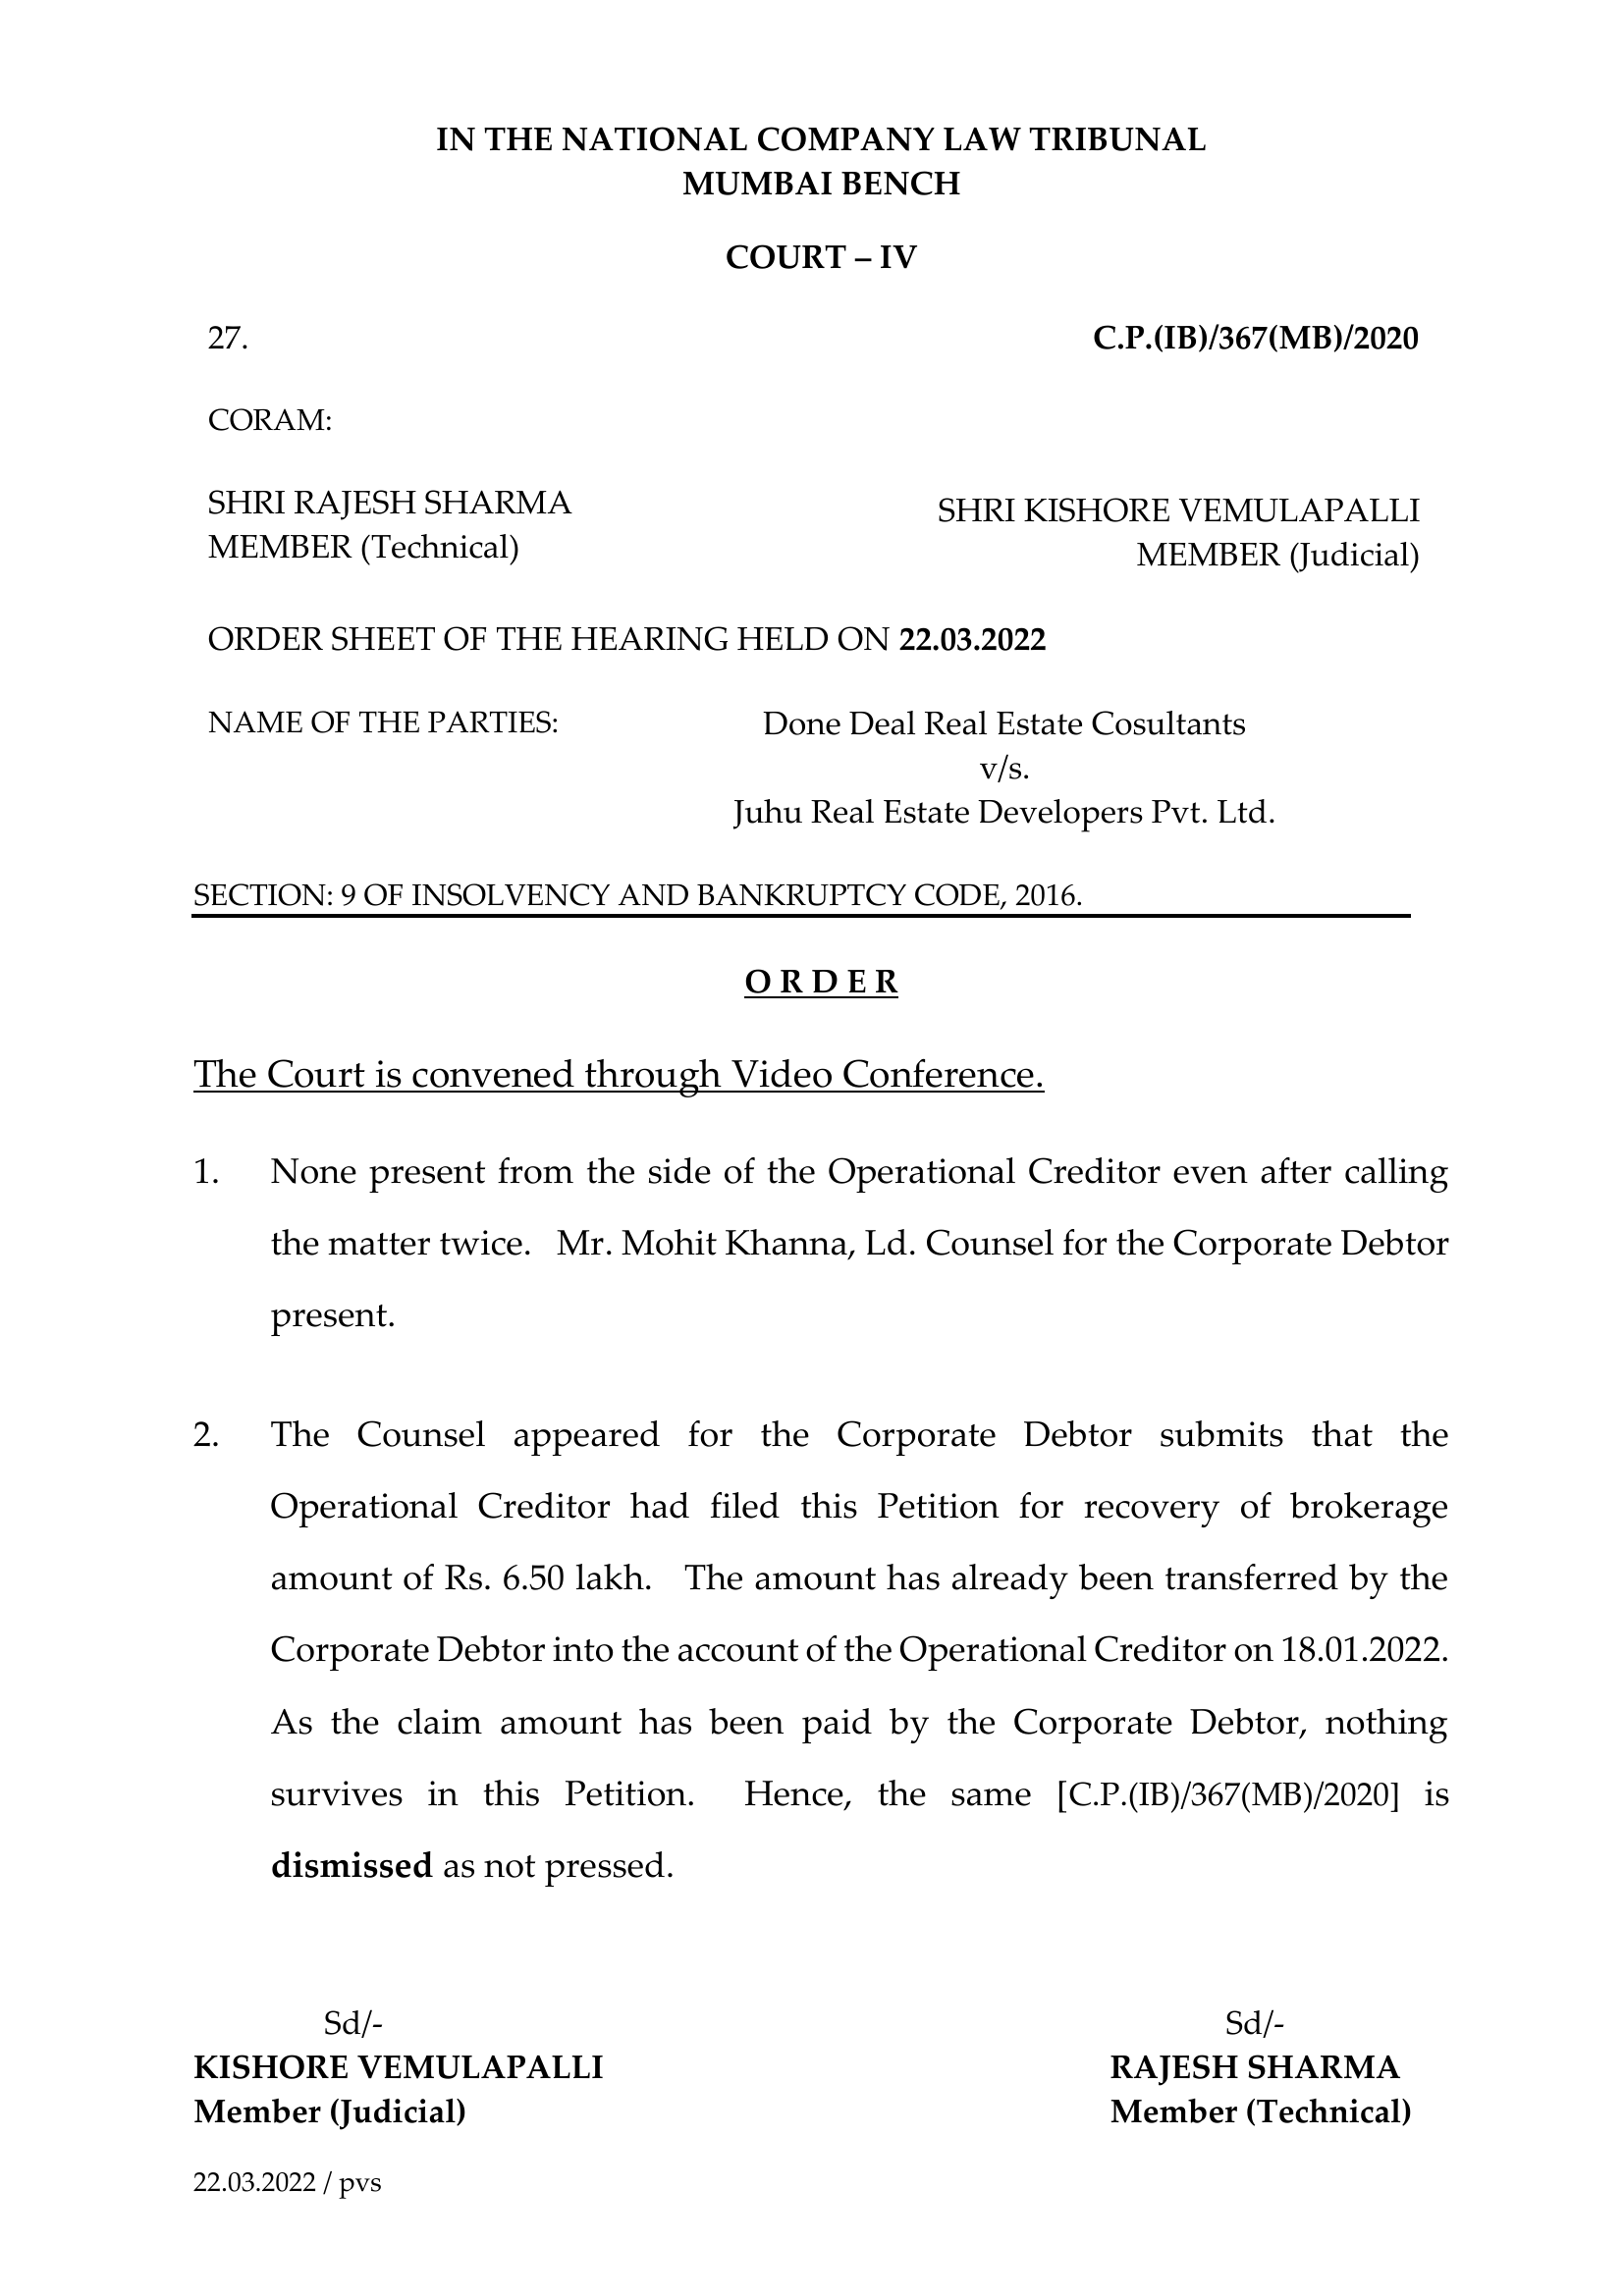

In [79]:
pdf_blob = df["pdf_blob"][144] # The blob of the first order

convert_from_bytes(pdf_blob)[0] # Displaying the first page of the order

<b> Figure 3: </b> Preview of sample order.

## 3.6 Extract text from PDFs

To apply NLP techniques, the text must first be extracted from the PDFs.

In most cases, the text is embedded in the PDF, which means it can be easily extracted. In other cases, optical character recognition (OCR) is used to extract the text, which means converting images of text into editable and searchable formats.

The `read_pdf_text_from_blob` function reads text from byte data. When text is embedded in the PDF, `pdfplumber` extracts it directly. If this extraction fails, `tesseract` applies OCR to retrieve the text.

While the extraction may not be flawless, it is generally adequate for NLP tasks. Instances where watermarks or handheld scanning hinder extraction exit, but they rare.

As an example, we extract the text of the first PDF file in the database, which is shown section 4.7.

In [80]:
read_pdf_text_from_blob(df["pdf_blob"][0])

'2-COMS-52-21.doc\nSharayu Khot.\nIN THE HIGH COURT OF JUDICATURE AT BOMBAY\nORDINARY ORIGINAL CIVIL JURISDICTION\nCOMMERCIAL SUIT NO. 52 OF 2021\nReliance Industries Limited …Plaintiff\nVersus\nThe New India Assurance Company\n…Defendants\nLimited & Ors.\n----------\nMs. Reshma Ranadive i/by A.S. Dayal and Associates for the\nPlaintiff.\nMr. Sankalp Srivastava iby M/s. Mulla & Mulla and Craigie\nBlunt and Caroe for the Defendant Nos. 1 to 8.\n----------\nCORAM : R.I. CHAGLA J\nDATE : 10 December 2021\nORDER :\n1. Learned Counsel appearing for the Plaintiff seeks\nleave of this Court to withdraw the Suit unconditionally.\nSPKAH HNA ODR TAUYRUANG\nDsSPKi AH Higg NnA Oite DR TadAUl lby YRyUANG 2. The Suit is disposed of as withdrawn.\nD21+07a 02:t 54e1 30:. 01:423.13\n3. Court fees are to be refunded in accordance with the\nRules. For the purposes of Section 43 of the Maharashtra Court\n1/2\n2-COMS-52-21.doc\nFees Act and the proviso to that Section, today’s date is the\ndate of making a

We use the `apply` method from `pandas` to extract the text of all the files. We store in new column called `pdf_text`.

In [81]:
df["pdf_text"] = df["pdf_blob"].apply(read_pdf_text_from_blob) # This will take some time to execute

In [82]:
df[['pdf_blob', 'pdf_name', 'pdf_text', 'disposal_type', 'reason']].head(3)

,pdf_blob,pdf_name,pdf_text,disposal_type,reason
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,2-COMS-52-21.doc\nSharayu Khot.\nIN THE HIGH C...,Withdrawn,No reason stated
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-1355-2019_10022020.pdf,3.coms-1355-19.doc\nsbw\nIN THE HIGH COURT OF ...,Withdrawn,No reason stated
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-172-2022_28062022.pdf,3-COMSL-8475-22.doc\nSharayu Khot.\nIN THE HIG...,Settlement,Consent terms


# 4. Unsupervised classification through Large Language Models

A major advantage of using large language models (LLMs) for this task is that they eliminate the need for labeled training data, which is often expensive and time-consuming to produce. Instead of relying on manually annotated datasets, the model leverages its pre-trained knowledge to analyze the text of court orders directly. It classifies orders by recognizing patterns and structures learned from extensive training on large text corpora.

In this unsupervised approach, the LLM identifies relevant features and characteristics of the text without predefined labels. We provide the LLM with instructions similar to the guidelines given to a law intern for making the classification. The model uses its contextual understanding and semantic insights to determine whether a court order is substantive or non-substantive, enabling effective classification without manual labeling.

We install and use Ollama, an open-source tool that facilitates working with LLMs locally. Ollama offers an easy-to-use interface for managing models, enabling deployment on local machines without requiring cloud-based solutions. Running LLMs locally, like the 27-billion-parameter Gemma 2 model by Google, provides flexibility and control. Other similar models can also be used in this setup.

Language model APIs by [OpenAI](https://platform.openai.com/), [Groq](https://groq.com/), can also be used instead of an LLM running locally.  

## 4.1 Setting up

In this cell, we download and install Ollama by executing a script from the Ollama website using a shell command. After installation, the Ollama server is started, and the specified model (`gemma2:27b`) is downloaded from the Ollama library.

The form input allows you to change the model, with a full list of available models found on their [website](https://ollama.com/library/).

The model runs in the background, enabling it to be used for processing tasks locally, without relying on cloud-based services.

**Note:** Commands starting with `!` are bash commands executed directly in the shell.

In [92]:
import subprocess
import shutil

MODEL_NAME = "deepseek-r1:7b" # @param {"type":"string","placeholder":"Model Name"}

# Check if ollama is already installed by looking for the 'ollama' command
if shutil.which("ollama") is None:
    # Install Ollama if it's not already installed
    subprocess.run("curl -fsSL https://ollama.com/install.sh | sh", shell=True, capture_output=True)
    print("Ollama installed.")
else:
    print("Ollama is already installed. Skipping installation.")

subprocess.run("nohup ollama serve &", shell=True, capture_output=True)

# Pull the model (replace MODEL_NAME with the actual model name)
subprocess.run(f"ollama pull {MODEL_NAME}", shell=True, capture_output=True)

# Run the model in the background
subprocess.run(f"nohup ollama run {MODEL_NAME} &", shell=True, capture_output=True)
print(f"Model {MODEL_NAME} is now running in the background.")

Ollama is already installed. Skipping installation.
Model deepseek-r1:7b is now running in the background.


We initiate the model using Langchain's Ollama constructor.

In [93]:
# @title 4.1.2 Initiate the LLM
llm = Ollama(model=MODEL_NAME, temperature=0)

## 4.2 Order classifying prompt

We prompt the LLM to classify the order using the same rules provided to law interns for labeling.

In this cell, we create a function that takes the order text as input and returns the disposal type and reason for disposal.

In [94]:

def classify_using_llm(llm, order_text):

  # Define the rules and keywords as specified in the HTML file
  prompt = f"""
  You will be provided a court order text. Your task is to identify disposal type of the court order ruling.

    There are five possible disposal types:

    1. Allowed
    - Keywords: Allowed, Sanctioned, Dissolution

    2. Dismissed
    - Keywords: Non-prosecution, Lack of pecuniary jurisdiction, Unable to prosecute, Infructuous, No proof of default, Inability to pay, Inability to incur expenditure, No IBC jurisdiction, Liability not crystallised

    3. Withdrawal
    - Keywords: No reason stated, Settled, Consent terms, Amount paid, Amount part paid

    4. Settlement
    - Keywords: Settled, Consent terms, Amount paid, Amount part paid

    5. Transferred
    - Keywords: Transfer

    Important points to note:
    *. Phrases like 'dismissed as' or 'disposed as' do not automatically indicate the disposal type. Examples:
    - "Dismissed as withdrawn" - Correct disposal type: Withdrawn
    - "Disposed as infructuous" - Correct disposal type: Dismissed
    *. If the analysis of the court order indicates any instance of withdrawal, classify the disposal type as "Withdrawn," regardless of any other disposal types present in the text. Withdrawal takes precedence over all other disposal types.
    *. When both a main case (MA) and interim case (IA) are referenced, prioritize the disposal type for the MA. Analyze the full text, avoiding reliance on phrases like "disposed" or "dismissed," and determine the disposal type and reason using the specified keywords.
    *. If the case was previously disposed as "Allowed," this remains the correct disposal type, even if the current hearing states it is "dismissed as infructuous." Ignore "dismissed as infructuous" in such cases.
    *. Handling "Settlement" and "Withdrawn"
    - If a settlement leads to the case being withdrawn, classify it as 'Withdrawn'.
    - If a settlement results in a formal agreement that resolves the case, classify it as 'Settlement'.
    *. The difference between 'Settlement' and 'Consent terms' is:
    - 'Settlement' generally involves monetary conpensation.
    - 'Consent terms' usually involves a compromise or agreement without any financial exchange.
    *. The disposal type and reason must strictly align with the provided keywords for each category.

    # Format Requirements
    - Return ONLY the disposal number (1-5)
    - No explanations or additional text
    - Example valid response: "Answer: 3"

    # Court Order Text:
    {order_text}

    - Return ONLY the disposal number (1-5)

    Answer:
    """

  # Use the model to classify the order
  classification = llm.invoke(prompt, seed = 123)

  return classification

In [95]:
import re

def extract_classification(disposal_type_llm_string):
    """
    Extracts numerical disposal type and reasoning from LLM response.
    Returns dictionary with 'disposal_label' and 'reason' keys.
    """
    result = {
        "disposal_label": "Unknown",
        "reason": None
    }

    # Extract reasoning from <think> tags
    reason_match = re.search(r'<think>(.*?)</think>', disposal_type_llm_string, re.DOTALL)
    if reason_match:
        result['reason'] = reason_match.group(1).strip()

    # Extract disposal number (enhanced pattern)
    number_match = re.search(r'\b([1-5])\b', disposal_type_llm_string[-4:].strip())


    if number_match:
        disposal_labels = {
            "1": "Allowed",
            "2": "Dismissed",
            "3": "Withdrawn",
            "4": "Settlement",
            "5": "Transferred"
        }
        result['disposal_label'] = disposal_labels.get(
            number_match.group(1),
            "Unknown"
        )

    return result

## 4.3 Classifying orders

In [96]:
df["pdf_text"][72]

'Roznama-MDRT-lll\nORDER in IA 617 of 2020 in OA No. 1930 of 2015\nBank of Baroda Applicant\n(Successor of Dena Bank)\nVs.\nKamal ]agnath ]adhav & Others\nMr. Anup Khaitan, Advocate, Counsel for Mr\nBank of\nset ex-parte\nfiled by was pending on the files\nof the Tribunal for Defendants were set ex-\nparte dueto\nApplicant an Application (IA) seeking to\naw the to arrived at with Defendants and\nhaving final settlement of\nthe\nmade out by the Applican! Tribunal\non record as IA No. 617 o{2020 and was heard through\ntoday when Advocate for Applicant placed his\nwith Bank Official present.\nAdvocate for Applicant, Tribunal passed the\nOrder:\nIA No. 617 of 2020 allowed\nDismissed Withdrawn\nAS\nRefund of Court as Per\nS.\nPlace: Mumbai Presiding\nDRT- Mumbai.\n'

In [97]:
disposal_type_llm = classify_using_llm(llm, df["pdf_text"][14])

In [89]:
 disposal_type_llm

'<think>\nOkay, so I need to figure out the disposal type of this court order. Let me start by reading through the provided text carefully.\n\nThe case is numbered 19-s-1071-2019 and involves Vijaykumar Chintaman Deshpande and Anr. as plaintiffs against Jasmine Vasantlal Gala and Ors. as defendants. The court order was dated August 20, 2019.\n\nLooking at the details:\n\n1. On August 9, 2019, consent terms were presented and filed in court. However, the suit wasn\'t numbered yet. Both parties were present on that date.\n2. Today (August 20), the learned counsel for the plaintiff states that the suit has been numbered. The defendants\' counsel have entered their appearance.\n\nThe order passed by the court includes several points:\n\n(i) An order and decree in terms of the consent terms signed by the parties and their advocates.\n(ii) The suit is dismissed against defendant nos. 2 to 4.\n(iii) Any undertakings are accepted.\n(iv) Time for depositing the amount under clause 11(a) is exte

In [90]:
extract_classification(disposal_type_llm)

{'disposal_label': 'Settlement',
 'reason': 'Okay, so I need to figure out the disposal type of this court order. Let me start by reading through the provided text carefully.\n\nThe case is numbered 19-s-1071-2019 and involves Vijaykumar Chintaman Deshpande and Anr. as plaintiffs against Jasmine Vasantlal Gala and Ors. as defendants. The court order was dated August 20, 2019.\n\nLooking at the details:\n\n1. On August 9, 2019, consent terms were presented and filed in court. However, the suit wasn\'t numbered yet. Both parties were present on that date.\n2. Today (August 20), the learned counsel for the plaintiff states that the suit has been numbered. The defendants\' counsel have entered their appearance.\n\nThe order passed by the court includes several points:\n\n(i) An order and decree in terms of the consent terms signed by the parties and their advocates.\n(ii) The suit is dismissed against defendant nos. 2 to 4.\n(iii) Any undertakings are accepted.\n(iv) Time for depositing th

In [98]:
for index, row in tqdm(df.iterrows(), total=len(df)):
  core_text = row['pdf_text']
  classification = classify_using_llm(llm, core_text)
  disposal_type = extract_classification(classification)["disposal_label"]
  reason = extract_classification(classification)["reason"]
  df.at[index, 'disposal_type_llm'] = disposal_type
  df.at[index, 'reason_llm'] = reason
  print(df.at[index, 'disposal_type'])
  print(disposal_type)
  print("########")
  if disposal_type != df.at[index, 'disposal_type']:
    print(reason)
  else:
    print("correct disposal type")

  1%|▋                                                                                                  | 1/146 [00:10<25:40, 10.62s/it]

Withdrawn
Withdrawn
########
correct disposal type


  1%|█▎                                                                                                 | 2/146 [00:20<24:48, 10.33s/it]

Withdrawn
Withdrawn
########
correct disposal type


  2%|██                                                                                                 | 3/146 [00:29<22:45,  9.55s/it]

Settlement
Withdrawn
########
Alright, I need to determine the disposal type of the court order provided. Let me go through the text step by step.

First, looking at the court order, it mentions that the parties have settled their disputes and tendered Consent Terms dated 28th June 2022. The order states that these terms are taken on record and marked 'X' for identification. It also notes that the parties are present in Court and that the Consent Terms are in order, not contrary to law.

Next, it says the Suit is disposed of and decreed in accordance with the Consent Terms. This indicates a formal resolution through consent, which falls under the "Settlement" category because it involves an agreement leading to the termination of the case without further proceedings.

Additionally, point 5 mentions that Interim Applications do not survive and are disposed of, but since the main suit is settled via consent terms, this doesn't change the disposal type. The key here is the use of "Settlem

  3%|██▋                                                                                                | 4/146 [00:38<22:15,  9.41s/it]

Withdrawn
Withdrawn
########
correct disposal type


  3%|███▍                                                                                               | 5/146 [00:52<26:06, 11.11s/it]

Withdrawn
Withdrawn
########
correct disposal type


  4%|████                                                                                               | 6/146 [01:04<26:43, 11.45s/it]

Withdrawn
Withdrawn
########
correct disposal type


  5%|████▋                                                                                              | 7/146 [01:14<25:30, 11.01s/it]

Withdrawn
Withdrawn
########
correct disposal type


  5%|█████▍                                                                                             | 8/146 [01:24<24:33, 10.68s/it]

Settlement
Settlement
########
correct disposal type


  6%|██████                                                                                             | 9/146 [01:35<24:20, 10.66s/it]

Withdrawn
Withdrawn
########
correct disposal type


  7%|██████▋                                                                                           | 10/146 [01:48<26:03, 11.49s/it]

Withdrawn
Withdrawn
########
correct disposal type


  8%|███████▍                                                                                          | 11/146 [02:21<40:33, 18.02s/it]

Settlement
Settlement
########
correct disposal type


  8%|████████                                                                                          | 12/146 [02:33<35:48, 16.04s/it]

Withdrawn
Withdrawn
########
correct disposal type


  9%|████████▋                                                                                         | 13/146 [02:42<30:43, 13.86s/it]

Settlement
Settlement
########
correct disposal type


 10%|█████████▍                                                                                        | 14/146 [02:58<32:13, 14.65s/it]

Settlement
Settlement
########
correct disposal type


 10%|██████████                                                                                        | 15/146 [03:16<34:20, 15.73s/it]

Settlement
Withdrawn
########
Alright, I need to determine the disposal type of the court order provided. Let me go through the information step by step.

First, looking at the court order text, it's a case numbered 19-s-1071-2019 in the High Court of Judicature at Bombay under ordinary original civil jurisdiction. The plaintiffs are Vijaykumar Chintaman Deshpande and Anr., while the defendants include Jasmine Vasantlal Gala and Ors.

The order is delivered by Justice A.K. Menon on August 20, 2019. There are several points in the order:

1. Consent terms were presented but not numbered. The parties present on the 9th of August had their presence dispensed with today.
2. Learned counsel for plaintiffs states that the suit has been numbered accordingly, and defendants have entered appearance.

Then, the judge passes several orders:
(i) Order and decree in terms of consent terms signed by parties and Advocates.
(ii) Suit stands dismissed against defendants nos. 2 to 4.
(iii) Accept Undert

 11%|██████████▋                                                                                       | 16/146 [03:28<31:26, 14.51s/it]

Withdrawn
Withdrawn
########
correct disposal type


 12%|███████████▍                                                                                      | 17/146 [03:38<28:19, 13.17s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type of the court order provided. Let's break down the information step by step.

First, looking at the court order text, it mentions that the plaintiff, Jagdish D. Torpe, seeks leave to withdraw the suit with the liberty to file a fresh suit. This is indicated in point 1 where Dr. Chandrachud submits that the plaint has errors and rectification isn't necessary, so he wants to withdraw.

Point 2 states that the plaintiff is present and on his instructions, the suit is allowed to be withdrawn with the same liberty. The term "allowed" here suggests that the court granted permission for withdrawal.

Additionally, there's a mention of refund of court fees as per rules, but this doesn't directly relate to the disposal type.

The keywords provided are crucial: Allowed falls under the first category (1). Since the suit is being withdrawn with permission, it aligns with "Allowed" rather than other types like "Dismissed" or "S

 12%|████████████                                                                                      | 18/146 [04:03<36:00, 16.88s/it]

Settlement
Settlement
########
correct disposal type


 13%|████████████▊                                                                                     | 19/146 [04:51<55:04, 26.02s/it]

Settlement
Withdrawn
########
Alright, I need to determine the disposal type of this court order. Let me go through the text step by step.

First, looking at the provided court order text, it's a document with several sections and dates. The main points are about parties entering into consent terms on 23 August 2019. Then, there are orders regarding the suit being disposed of, notices of motion, interim orders being vacated, and some undertakings by counsel.

I remember that the keywords for each disposal type are important here. Let me list them again:

1. Allowed: Keywords include Allowed, Sanctioned, Dissolution.
2. Dismissed: Keywords like Non-prosecution, Lack of pecuniary jurisdiction, Unable to prosecute, etc.
3. Withdrawal: Keywords such as No reason stated, Settled, Consent terms, Amount paid, etc.
4. Settlement: Keywords include Settled, Consent terms, Amount paid, etc.
5. Transferred: Keyword is Transfer.

The text mentions that the parties have entered into consent terms an

 14%|█████████████▍                                                                                    | 20/146 [05:09<50:00, 23.82s/it]

Settlement
Settlement
########
correct disposal type


 14%|██████████████                                                                                    | 21/146 [05:22<42:37, 20.46s/it]

Withdrawn
Withdrawn
########
correct disposal type


 15%|██████████████▊                                                                                   | 22/146 [05:37<38:37, 18.69s/it]

Settlement
Dismissed
########
Alright, I need to determine the disposal type from the given court order text. Let me go through it step by step.

First, I'll read the court order carefully. The main points are about a consent agreement between the parties and the dismissal of the case based on that.

Looking at section 3: "The Suit is disposed of in accordance with the Consent Terms. In view of this, Notice of Motion does not survive and is disposed of as infructuous." This seems to indicate that the suit was dismissed because the consent terms were accepted.

Now, I need to check if there are any keywords related to each disposal type. The relevant keywords for each type are:

1. Allowed: Keywords like Allowed, Sanctioned, Dissolution.
2. Dismissed: Keywords such as Non-prosecution, Lack of pecuniary jurisdiction, Unable to prosecute, etc.
3. Withdrawal: Keywords like No reason stated, Settled, Consent terms, Amount paid, etc.
4. Settlement: Keywords including Settled, Consent terms, 

 16%|███████████████▍                                                                                  | 23/146 [05:51<35:41, 17.41s/it]

Withdrawn
Withdrawn
########
correct disposal type


 16%|████████████████                                                                                  | 24/146 [06:14<38:34, 18.97s/it]

Withdrawn
Withdrawn
########
correct disposal type


 17%|████████████████▊                                                                                 | 25/146 [06:36<40:28, 20.07s/it]

Settlement
Settlement
########
correct disposal type


 18%|█████████████████▍                                                                                | 26/146 [06:44<32:39, 16.33s/it]

Withdrawn
Withdrawn
########
correct disposal type


 18%|██████████████████                                                                                | 27/146 [07:04<34:33, 17.42s/it]

Settlement
Settlement
########
correct disposal type


 19%|██████████████████▊                                                                               | 28/146 [07:15<30:17, 15.40s/it]

Withdrawn
Withdrawn
########
correct disposal type


 20%|███████████████████▍                                                                              | 29/146 [07:28<29:02, 14.89s/it]

Withdrawn
Withdrawn
########
correct disposal type


 21%|████████████████████▏                                                                             | 30/146 [07:47<31:04, 16.07s/it]

Settlement
Settlement
########
correct disposal type


 21%|████████████████████▊                                                                             | 31/146 [07:56<26:33, 13.86s/it]

Withdrawn
Withdrawn
########
correct disposal type


 22%|█████████████████████▍                                                                            | 32/146 [09:02<56:21, 29.66s/it]

Withdrawn
Withdrawn
########
correct disposal type


 23%|█████████████████████▋                                                                          | 33/146 [10:17<1:21:32, 43.30s/it]

Settlement
Dismissed
########
Alright, I need to determine the disposal type of the court order provided. Let me go through the text step by step.

First, I'll read the court order carefully. The main parties are Umanand Apartment Co-operative Housing Society Ltd., Mumbai and Ors. as plaintiffs, and Class Apart (India) Pvt. Ltd., Mumbai and Ors. as defendants. 

Looking at the sections, there's a mention of "Notice of Motion No.1535 of 2019" and "Commercial Suit No.860 of 2019." The parties are seeking a decree based on consent terms. 

In the P.C. section, it says that learned counsel for the plaintiffs tenders consent terms signed between the plaintiffs and defendants Nos.1, 2, and 6. They argue that defendants Nos.3,4,5 are not directors of the first defendant, so the suit against them is being withdrawn as per clause 50 of the consent terms. Similarly, there's no claim against defendants Nos.7 and 8.

The judge then passes an order: (i) recording the consent terms, (ii) decree in t

 23%|██████████████████████▎                                                                         | 34/146 [10:31<1:03:56, 34.25s/it]

Withdrawn
Withdrawn
########
correct disposal type


 24%|███████████████████████▍                                                                          | 35/146 [10:40<49:46, 26.90s/it]

Settlement
Settlement
########
correct disposal type


 25%|████████████████████████▏                                                                         | 36/146 [10:51<40:07, 21.88s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify which keyword corresponds to each possible disposal type.

First, the court order mentions that Mr. Singh is seeking to withdraw the suit. The text says, "On his application, suit is allowed to be withdrawn." That immediately stands out because one of the keywords for Allowed is "Allowed," and here it's explicitly stated as being withdrawn with the permission or consent from the plaintiff.

Now, looking at the other points: the court mentions disposing of interim applications and refunding if necessary. But since the main point is about withdrawal, which has a keyword in this case, I don't need to consider the others unless there are multiple keywords conflicting. However, according to the instructions, if a settlement leads to withdrawal, it's classified as 'Withdrawn.' Here, it's a direct withdrawal based on the plaintiff's ap

 25%|████████████████████████▊                                                                         | 37/146 [11:08<37:31, 20.66s/it]

Settlement
Settlement
########
correct disposal type


 26%|█████████████████████████▌                                                                        | 38/146 [11:27<36:17, 20.16s/it]

Allowed
Allowed
########
correct disposal type


 27%|██████████████████████████▏                                                                       | 39/146 [11:39<31:18, 17.56s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type for the given court order text. Let me go through it step by step.

First, I'll read the provided court order text carefully. The main points are:

1. The plaintiff, Shephali, is seeking an unconditional withdrawal of the suit.
2. The court mentions that the suit is dismissed as withdrawn on October 20, 2021.
3. There's a notice of motion (L) number 1672 of 2019, which was noticed but not served yet.

Looking at the keywords for each disposal type:

- Allowed: Keywords are Allowed, Sanctioned, Dissolution. I don't see any mention here.
- Dismissed: Keywords include Non-prosecution, Infructuous, etc. The text says "dismissed as withdrawn," which is a dismissal but with a reason (withdrawn).
- Withdrawal: Keywords like No reason stated, Settled, Consent terms, Amount paid, etc. However, the court explicitly states it's being withdrawn.
- Settlement: Keywords are Settled and Consent terms. But here, it's a withdrawa

 27%|██████████████████████████▊                                                                       | 40/146 [12:08<37:15, 21.09s/it]

Settlement
Settlement
########
correct disposal type


 28%|███████████████████████████▌                                                                      | 41/146 [12:20<31:48, 18.18s/it]

Settlement
Settlement
########
correct disposal type


 29%|████████████████████████████▏                                                                     | 42/146 [12:30<27:40, 15.97s/it]

Settlement
Settlement
########
correct disposal type


 29%|████████████████████████████▊                                                                     | 43/146 [12:40<23:58, 13.96s/it]

Withdrawn
Withdrawn
########
correct disposal type


 30%|█████████████████████████████▌                                                                    | 44/146 [12:54<24:03, 14.15s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text from a high court in Bombay dealing with an ordinary original civil suit between Export Import Bank of India and Essar Telecom Limited. The case number is 643 of 2019.

Looking at the text, there are several paragraphs. The first paragraph mentions that the learned counsel for the plaintiff has submitted that the suit has been settled out of court and seeks withdrawal. Then it says "Suit is allowed to be withdrawn." That seems important because one of the keywords here is "allowed," which corresponds to disposal type 1.

Next, there's a mention of "Pending notice of motion shall also stand disposed" and "Refund as per rules." These don't directly relate to the main disposal decision but are part of the court order structure. 

I need to check if any other keywords might apply. The text doesn't use words like "Dismissed," "Settled," or "Transferred," so those would be

 31%|██████████████████████████████▏                                                                   | 45/146 [13:06<22:30, 13.37s/it]

Withdrawn
Withdrawn
########
correct disposal type


 32%|██████████████████████████████▉                                                                   | 46/146 [13:18<21:43, 13.03s/it]

Settlement
Withdrawn
########
Alright, let's try to figure out the disposal type for this court order. So, first, I'll read through the text carefully.

The case is a Commercial Summary Suit No.63 of 2021 between Sunil Biyani and R. B. Mining & Company and Ors. The parties' counsel mentioned that they've reached an agreement and are seeking to file consent terms. All parties were present, and their respective authority letters have been tendered.

Looking at the keywords provided:

1. Allowed: Keywords include Allowed, Sanctioned, Dissolution.
2. Dismissed: Keywords like Non-prosecution, etc., but I don't see any here.
3. Withdrawal: Keywords such as No reason stated, Settled, etc. The text mentions a settlement and filing consent terms, which might indicate withdrawal.
4. Settlement: Keywords include Settled, Consent terms, Amount paid, etc. Again, the parties are seeking to file consent terms after reaching an agreement.
5. Transferred: Keyword is Transfer.

The court order states th

 32%|███████████████████████████████▌                                                                  | 47/146 [13:33<22:26, 13.60s/it]

Settlement
Settlement
########
correct disposal type


 33%|████████████████████████████████▏                                                                 | 48/146 [13:48<22:46, 13.95s/it]

Settlement
Transferred
########
Alright, I need to determine the disposal type of the court order provided. Let me go through the text step by step.

First, I'll read the court order text carefully. The case is about Baheram Homi Guard and Ors. vs Shubham Enterprises and Ors., with parties represented by their legal teams. 

Looking at the sections, there's a part where it mentions "Parties have entered into further consent terms dated 12.02.2019." This indicates that both sides have agreed to certain terms. Then, it states that all undertakings accepted, meaning the defendants have agreed to honor the terms set by the court.

The key point here is the mention of "consent terms" and the acceptance of these terms by the defendants. In legal contexts, when a party accepts a consent order, it often leads to the disposal of the case as the issues are resolved without further proceedings. 

I also need to check if there's any indication that the case was dismissed or terminated. The text do

 34%|████████████████████████████████▉                                                                 | 49/146 [13:59<21:17, 13.18s/it]

Withdrawn
Withdrawn
########
correct disposal type


 34%|█████████████████████████████████▌                                                                | 50/146 [14:07<18:30, 11.57s/it]

Withdrawn
Withdrawn
########
correct disposal type


 35%|██████████████████████████████████▏                                                               | 51/146 [14:58<37:04, 23.41s/it]

Allowed
Allowed
########
correct disposal type


 36%|██████████████████████████████████▉                                                               | 52/146 [15:20<35:53, 22.91s/it]

Allowed
Allowed
########
correct disposal type


 36%|███████████████████████████████████▌                                                              | 53/146 [15:42<35:01, 22.59s/it]

Withdrawn
Dismissed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text from a court order and need to determine if it falls into one of five categories: Allowed, Dismissed, Withdrawn, Settlement, or Transferred.

First, I'll read through the provided text carefully. The court order is in the format of an order sheet with some details about cases and actions taken. 

Looking at point 1: It mentions that the learned counsel's request to adjourn further was rejected, and she keeps requesting for adjournment to withdraw the application. However, it also states that the matter has been amicably settled between the parties. So here, there's a mention of settlement.

Point 2 says that the Original Application No.1216 is being dismissed "for want of prosecution with no order as to costs." That seems like a dismissal keyword because it mentions lack of prosecution and no cost order.

Now, according to the important points provided, if both a m

 37%|████████████████████████████████████▏                                                             | 54/146 [15:55<30:38, 19.98s/it]

Withdrawn
Withdrawn
########
correct disposal type


 38%|████████████████████████████████████▉                                                             | 55/146 [16:32<38:00, 25.06s/it]

Withdrawn
Withdrawn
########
correct disposal type


 38%|█████████████████████████████████████▌                                                            | 56/146 [16:43<31:17, 20.86s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, first, I'll read through the text carefully.

The court order starts with some details about a case involving Bhaskar Govind Hindalekar and ICICI Bank Ltd. There are mentions of advocates appearing for both parties. Then, in point 1, it says the applicant is seeking withdrawal because the matter is settled. That immediately makes me think of the "Withdrawal" category.

Moving on to point 2, it talks about payment under an OTS scheme being fully paid by the defendant's bank. This seems like a settlement since all payments are done as per agreed terms. Then in point 3, the court dismisses the matter as settled after considering the payment and NOC from the applicant.

Now, according to the rules, if there's any mention of withdrawal, even if other dispositions are present, we should classify it as "Withdrawn." Also, when both MA (main case) and IA (interim case) are referenced, we prio

 39%|██████████████████████████████████████▎                                                           | 57/146 [16:53<25:49, 17.41s/it]

Allowed
Allowed
########
correct disposal type


 40%|██████████████████████████████████████▉                                                           | 58/146 [17:03<22:21, 15.24s/it]

Withdrawn
Withdrawn
########
correct disposal type


 40%|███████████████████████████████████████▌                                                          | 59/146 [17:15<20:42, 14.29s/it]

Withdrawn
Withdrawn
########
correct disposal type


 41%|████████████████████████████████████████▎                                                         | 60/146 [17:23<17:35, 12.27s/it]

Dismissed
Dismissed
########
correct disposal type


 42%|████████████████████████████████████████▉                                                         | 61/146 [17:32<16:06, 11.37s/it]

Dismissed
Dismissed
########
correct disposal type


 42%|█████████████████████████████████████████▌                                                        | 62/146 [18:22<32:12, 23.01s/it]

Dismissed
Unknown
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text that seems to be from a legal proceeding, probably involving some kind of case between M/s. Uma Petroproducts India Limited and South Indian Bank along with other entities.

First, I'll read through the text carefully. The first paragraph mentions "Roznama in MA 10 of 2015" which is likely the main application number. Then it lists the parties involved: the applicant (M/s. Uma Petroproducts India Limited) and the respondents (South Indian Bank and Ors., which probably means other banks or entities).

Next, there's a section where neither party has appeared for the applicant earlier, and even today, no one has appeared. That seems significant because in many court processes, if both parties are present, it can affect the outcome.

The text then states that the present matter is dismissed for default. The reason given is "applicant has lost interest." So, looking at th

 43%|██████████████████████████████████████████▎                                                       | 63/146 [18:38<29:05, 21.03s/it]

Dismissed
Dismissed
########
correct disposal type


 44%|██████████████████████████████████████████▉                                                       | 64/146 [19:05<31:02, 22.72s/it]

Allowed
Allowed
########
correct disposal type


 45%|███████████████████████████████████████████▋                                                      | 65/146 [19:52<40:34, 30.06s/it]

Withdrawn
Unknown
########
Alright, I need to determine the disposal type for this court order. Let's break down the information given.

First, looking at the keywords provided:

1. Allowed: Keywords are Allowed, Sanctioned, Dissolution.
2. Dismissed: Keywords include Non-prosecution, Lack of pecuniary jurisdiction, Unable to prosecute, Infructuous, No proof of default, Inability to pay, Inability to incur expenditure, No IBC jurisdiction, Liability not crystallised.
3. Withdrawal: Keywords are No reason stated, Settled, Consent terms, Amount paid, Amount part paid.
4. Settlement: Keywords include Settled, Consent terms, Amount paid, Amount part paid.
5. Transferred: Keyword is Transfer.

Now, looking at the court order text:

The order states that IA No. 640 of 2020 is "Allowed and OA No. 1599 of 2016 stands Dismissed as Withdrawn." 

Wait, so the main case (MA) is OA No. 1599 of 2016, which was dismissed as withdrawn. The interim case (IA) is IA No. 640 of 2020, which is allowed.

Bu

 45%|████████████████████████████████████████████▎                                                     | 66/146 [20:10<35:00, 26.25s/it]

Withdrawn
Withdrawn
########
correct disposal type


 46%|████████████████████████████████████████████▉                                                     | 67/146 [20:51<40:20, 30.64s/it]

Settlement
Settlement
########
correct disposal type


 47%|█████████████████████████████████████████████▋                                                    | 68/146 [22:00<54:51, 42.20s/it]

Withdrawn
Unknown
########
Alright, I need to determine the disposal type for this court order. Let me go through the text step by step.

First, looking at the court order text provided, it mentions "IA No. 599 of 2020" and "OA No.1106 of 2016." The applicant is seeking a settlement, which suggests that the keyword "Settlement" might be relevant here. However, I also see an entry at the end that says "Dismissed as Withdrawn."

The instructions mention that if both a main case (MA) and interim case (IA) are referenced, prioritize the disposal type for the MA. In this text, the main case is OA No.1106 of 2016, which was previously disposed of as "Allowed." But now, in IA No.599 of 2020, it's being dismissed as withdrawn.

Wait, but according to the important points, if a case was previously disposed as "Allowed," that remains correct even if another disposition is mentioned. So OA No.1106 is still "Allowed." However, the focus here is on IA No.599 of 2020, which ends with "Dismissed as W

 47%|█████████████████████████████████████████████▎                                                  | 69/146 [23:18<1:07:54, 52.92s/it]

Withdrawn
Unknown
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text that describes an appeal case involving Roznama in Appeal 11 of 2017 between Nimish Bhishma Thakore and IDBI Bank. The advocate for the appellant is Mr. Jamshed Ansari.

Looking at the text, there are several key points:

1. The matter is scheduled via video conferencing because of the Covid-19 pandemic.
2. There's an Interim Application (IA) No. 21/2022.
3. In point 1, the counsel for the applicant is seeking permission to withdraw the appeal.
4. In point 2, the appellant's counsel submits that during the pendency of the appeal, a loan account or amount recoverable by the respondent was settled by the applicant. The applicant mentions that the respondent bank has accepted a payment proposal of Rs. 52,60,134.42/- and that Recovery Proceeding No. 233 of 2022 is closed.
5. In point 3, based on these submissions, the court allows the IA.
6. In point 4, the appeal is dis

 48%|██████████████████████████████████████████████▉                                                   | 70/146 [23:29<51:09, 40.39s/it]

Dismissed
Dismissed
########
correct disposal type


 49%|███████████████████████████████████████████████▋                                                  | 71/146 [23:42<40:20, 32.27s/it]

Withdrawn
Withdrawn
########
correct disposal type


 49%|████████████████████████████████████████████████▎                                                 | 72/146 [23:55<32:32, 26.38s/it]

Withdrawn
Withdrawn
########
correct disposal type


 50%|█████████████████████████████████████████████████                                                 | 73/146 [24:20<31:34, 25.95s/it]

Withdrawn
Withdrawn
########
correct disposal type


 51%|█████████████████████████████████████████████████▋                                                | 74/146 [24:34<27:07, 22.60s/it]

Withdrawn
Withdrawn
########
correct disposal type


 51%|██████████████████████████████████████████████████▎                                               | 75/146 [24:49<23:51, 20.16s/it]

Withdrawn
Withdrawn
########
correct disposal type


 52%|███████████████████████████████████████████████████                                               | 76/146 [25:00<20:14, 17.35s/it]

Settlement
Allowed
########
Alright, I need to determine the disposal type of this court order. Let's go through it step by step.

First, looking at the text provided, there are several sections. The key part is where the parties submitted consent terms. In section 3, the applicant's counsel submits that they've filed the consent terms today, which may be taken on record. Then in section 4, the defendant also accepts these consent terms without any coercion or undue influence.

Moving further down, it says that based on these submissions, the request is allowed. So, "allowed" seems to be the keyword here. The court order mentions that OA No. 153 of 2015 stands disposed of with no order as to costs. 

I should check if there are any other keywords that might indicate a different disposal type. Looking through the text again, I don't see any mentions of dismissed, withdrawn, settlement, or transferred. The main action is allowing the consent terms, which falls under Allowed.

Also, accor

 53%|███████████████████████████████████████████████████▋                                              | 77/146 [25:14<18:59, 16.51s/it]

Dismissed
Dismissed
########
correct disposal type


 53%|████████████████████████████████████████████████████▎                                             | 78/146 [25:49<24:45, 21.84s/it]

Allowed
Allowed
########
correct disposal type


 54%|█████████████████████████████████████████████████████                                             | 79/146 [26:06<22:59, 20.59s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type of the court order provided. Let's break down the information step by step.

First, looking at the court order text, it mentions that the matter is taken up through a Virtual Hearing. The parties involved are DENA BANK as the financial creditor and GHRUSHNESHWAR SUGARS PVT. LTD. as the corporate debtor.

The order refers to IA-2425/2021, which is filed by the Bank of Baroda Financial Creditor with a Consent Terms attached. The counsel for the financial creditor states that the corporate debtor has already paid 50% of the settled amount up to 30.09.2021. The remaining balance of Rs. 134.87 Crores is to be paid by 31.12.2021 under settlement consent terms.

The bench considers these submissions and concludes that since a substantial amount has been paid, there's no reason to keep the Company Petition alive. Therefore, IA-2425/2021 is allowed and disposed of.

Now, looking at the keywords for each disposal type:

1.

 55%|█████████████████████████████████████████████████████▋                                            | 80/146 [26:24<21:45, 19.78s/it]

Dismissed
Allowed
########
Alright, so I'm trying to figure out whether this petition is maintainable under Section 7 of the Insolvency and Bankruptcy Code, 2016. The petitioner is a Financial Creditor who wants to initiate a Corporate Insolvency Resolution Process against a Co-operative Society registered under the Maharashtra State Co-Operative Societies Act, 1960.

First, I need to understand what Section 7 of the I&B Code entails. From what I remember, Section 7 allows individuals or entities (referred to as "Creditors") to file insolvency petitions if they are entitled to do so under the Insolvency and Bankruptcy Act, 2016. However, there might be exceptions based on the type of entity involved.

Looking at point g in the judgment, it mentions that the Central Government has not issued notifications for CIRP (Corporate Insolvency Resolution Process) specifically for Co-operative Societies. This suggests that such entities are outside the scope of the provisions under Section 7 bec

 55%|██████████████████████████████████████████████████████▎                                           | 81/146 [26:53<24:23, 22.51s/it]

Withdrawn
Withdrawn
########
correct disposal type


 56%|███████████████████████████████████████████████████████                                           | 82/146 [27:55<36:44, 34.44s/it]

Withdrawn
Unknown
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify which keyword corresponds to each disposal type.

First, the court is handling a case under the Insolvency and Bankruptcy Code of 2016. The parties involved are Ambrish Kumar Pandya as the petitioner and Rolta Defence Technology Systems Pvt Ltd as the corporate debtor. 

In section 9, it mentions that the court is convened via a video conference. Then, looking at the submissions, the counsel for the petitioner, Mr. Udayashankar Samudrala, submits that the corporate debtor has paid the claim amount and seeks withdrawal of the petition. So, he's asking to withdraw this case.

The text then states: "C.P. (IB)/1053(MB)2020 is dismissed as withdrawn." That seems like a dismissal with the reason being withdrawal. But I also notice that there's another entry for IA 2262/2020, which stands disposed of without any specific reason mention

 57%|███████████████████████████████████████████████████████▋                                          | 83/146 [28:10<29:53, 28.47s/it]

Allowed
Allowed
########
correct disposal type


 58%|████████████████████████████████████████████████████████▍                                         | 84/146 [28:24<24:54, 24.10s/it]

Withdrawn
Withdrawn
########
correct disposal type


 58%|█████████████████████████████████████████████████████████                                         | 85/146 [28:41<22:21, 22.00s/it]

Allowed
Unknown
########
Alright, so I'm trying to figure out what the user is asking for here. They provided a long document that seems to be related to company law, specifically dealing with an income tax scheme and some legal references like the IT Act 1961 and CAA 2019. The user then asks me to "Return ONLY the disposal number (1-5)" based on this document.

First, I need to understand what a disposal number refers to in this context. In legal documents or orders, a disposal number is often an identifier assigned by the court or regulatory body to each case or order they process. It helps in tracking and referencing specific rulings or judgments.

Looking at the provided document, it's structured with various sections (IV(a) to IV(k)), which likely contain the arguments made by the petitioner companies and the responses from the Regional Director. Then there are numbered paragraphs (9-16) that outline the decision-making process: explanations, affirmations, and orders.

The user wa

 59%|█████████████████████████████████████████████████████████▋                                        | 86/146 [28:57<20:09, 20.15s/it]

Dismissed
Dismissed
########
correct disposal type


 60%|██████████████████████████████████████████████████████████▍                                       | 87/146 [29:11<17:59, 18.30s/it]

Dismissed
Dismissed
########
correct disposal type


 60%|███████████████████████████████████████████████████████████                                       | 88/146 [29:26<16:55, 17.51s/it]

Allowed
Transferred
########
Alright, so I'm trying to figure out what the disposal number is for this case based on the provided document. Let me start by reading through the document carefully.

The document seems to be a legal document from a company regarding an amalgamation or merger process. There are mentions of Companies Act, 2015, and various sections like 34, 36, etc., which I know relate to amalgamation and dissolution of companies.

Looking at the end of the document, there's a paragraph that says: "With the above directions, CA-326/2022 in C.A.(CAA)/18(MB)/2022 is allowed and disposed of." This seems like a key part because it mentions the order being disposed of.

Now, I need to determine which disposal number this corresponds to. The options are 1 through 5 based on the initial query. Since the document doesn't explicitly list numbers before this point, but in legal documents, each significant action often gets a disposal number as per the court's process.

Given that it

 61%|███████████████████████████████████████████████████████████▋                                      | 89/146 [29:40<15:38, 16.46s/it]

Dismissed
Dismissed
########
correct disposal type


 62%|████████████████████████████████████████████████████████████▍                                     | 90/146 [29:57<15:22, 16.48s/it]

Dismissed
Dismissed
########
correct disposal type


 62%|█████████████████████████████████████████████████████████████                                     | 91/146 [30:16<15:53, 17.34s/it]

Dismissed
Dismissed
########
correct disposal type


 63%|█████████████████████████████████████████████████████████████▊                                    | 92/146 [30:29<14:26, 16.05s/it]

Dismissed
Dismissed
########
correct disposal type


 64%|██████████████████████████████████████████████████████████████▍                                   | 93/146 [30:51<15:38, 17.72s/it]

Dismissed
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify any keywords related to each category.

First, the court is handling a company petition where Infosoft Global Pvt Ltd., a financial creditor, is against Bombay Rayon Fashions Ltd., the corporate debtor. The key part here seems to be that the CIRP (Corporate Insolvency Resolution Process) was admitted on 07.06.2022 for CP (IB) 1443 of 2022. Then, it mentions that CP (IB) 298/MB/2020 is rendered infructuous and stands closed.

Looking at the keywords:

- Allowed: Keywords are Allowed, Sanctioned, Dissolution. I don't see any here.
- Dismissed: Keywords include Non-prosecution, Infructuous, etc. The order says CP 298/MB/2020 is rendered infructuous, which fits into this category.
- Withdrawal: Keywords like No reason stated, Settled, Consent terms, Amount paid. Not present here.
- Settlement: Keywords include Settled, Consent terms

 64%|███████████████████████████████████████████████████████████████                                   | 94/146 [31:00<13:08, 15.17s/it]

Withdrawn
Withdrawn
########
correct disposal type


 65%|███████████████████████████████████████████████████████████████▊                                  | 95/146 [31:18<13:30, 15.88s/it]

Withdrawn
Withdrawn
########
correct disposal type


 66%|████████████████████████████████████████████████████████████████▍                                 | 96/146 [31:33<13:00, 15.61s/it]

Withdrawn
Withdrawn
########
correct disposal type


 66%|█████████████████████████████████████████████████████████████████                                 | 97/146 [31:49<12:52, 15.77s/it]

Withdrawn
Withdrawn
########
correct disposal type


 67%|█████████████████████████████████████████████████████████████████▊                                | 98/146 [32:01<11:42, 14.63s/it]

Allowed
Allowed
########
correct disposal type


 68%|██████████████████████████████████████████████████████████████████▍                               | 99/146 [32:16<11:41, 14.93s/it]

Dismissed
Dismissed
########
correct disposal type


 68%|██████████████████████████████████████████████████████████████████▍                              | 100/146 [32:29<10:57, 14.30s/it]

Allowed
Allowed
########
correct disposal type


 69%|███████████████████████████████████████████████████████████████████                              | 101/146 [32:38<09:34, 12.77s/it]

Withdrawn
Withdrawn
########
correct disposal type


 70%|███████████████████████████████████████████████████████████████████▊                             | 102/146 [32:54<10:01, 13.66s/it]

Allowed
Allowed
########
correct disposal type


 71%|████████████████████████████████████████████████████████████████████▍                            | 103/146 [33:11<10:26, 14.58s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type of the court order provided. Let's break down the information step by step.

First, looking at the court order text, it mentions that the matter was taken up through a Virtual Hearing on 04.01.2022. The parties involved are PRAKUL THADI as the applicant and others as respondents or petitioner. 

The key part is where it states: "IA 2954/2021:- ... seeking orders for withdrawal of the Corporate Insolvency Resolution Process...". It then mentions that the Financial Creditor and the company have entered into consent terms dated 14.12.2021 to settle their dispute.

Further down, it says: "In view of above submissions and on perusal of documents placed on record before this bench enclosing therewith, copy of the consent terms reached between the parties, nothing survives in the present Company Petition." 

Then, it concludes with: "CP (IB) No. 348/MB/2020 rendered infructuous, hence stands closed. The IA 2954/2021 is 

 71%|█████████████████████████████████████████████████████████████████████                            | 104/146 [33:24<09:55, 14.17s/it]

Dismissed
Dismissed
########
correct disposal type


 72%|█████████████████████████████████████████████████████████████████████▊                           | 105/146 [34:11<16:22, 23.96s/it]

Withdrawn
Withdrawn
########
correct disposal type


 73%|██████████████████████████████████████████████████████████████████████▍                          | 106/146 [34:29<14:53, 22.33s/it]

Withdrawn
Withdrawn
########
correct disposal type


 73%|███████████████████████████████████████████████████████████████████████                          | 107/146 [35:01<16:19, 25.10s/it]

Dismissed
Settlement
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text from a court order and need to determine if it falls into one of the five categories: Allowed, Dismissed, Withdrawn, Settlement, or Transferred.

First, I'll read through the provided text carefully. The case is numbered 2. I.A. 814/2022, and it's under the section dealing with Insolvency and Bankruptcy Code, 2016. 

Looking at point 2 in the order: "In view of settlement agreed between the parties, an order of dismissal of C.P(IB)637(MB)/2021 was passed by this Bench on 23.03.2022." So here, the court dismissed a case as part of a settlement.

Then, point 3 says: "In view of dismissal of main company Petition, nothing survives in I.A. 814/2022, hence dismissed as infructuous." This mentions being dismissed as infructuous because nothing survived from the main petition.

Now, according to the important points provided, if both a main case (MA) and an interim case 

 74%|███████████████████████████████████████████████████████████████████████▊                         | 108/146 [35:14<13:32, 21.38s/it]

Allowed
Allowed
########
correct disposal type


 75%|████████████████████████████████████████████████████████████████████████▍                        | 109/146 [35:29<12:02, 19.52s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, first, I'll read through the text carefully.

The case is IA 266/2020 and CP 1378/2017. The judge is SHRI SHYAM BABU GAUTAM JUSTICE P. N. DESHMUKH. 

Looking at the order, it mentions that the matter was taken up through a virtual hearing (VC). Then, under IA 266 of 2020, both parties' counsel appeared. The operational creditor has settled with the corporate debtor and wants to withdraw the company petition. The corporate debtor's counsel filed an affidavit stating no pending proceedings under sections 7 or 9 before any bench of NCLT in Mumbai.

The bench notes this affidavit and the submissions made by the applicant, then allows IA 266/2020 and closes CP 1378/2017. 

Now, looking at the keywords for each disposal type:

1. Allowed: Keywords are Allowed, Sanctioned, Dissolution.
   - The order says "IA 266 of 2020 is allowed," so this fits.

2. Dismissed: Keywords like Non-prosecutio

 75%|█████████████████████████████████████████████████████████████████████████                        | 110/146 [35:49<11:45, 19.58s/it]

Withdrawn
Withdrawn
########
correct disposal type


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 111/146 [36:16<12:44, 21.83s/it]

Withdrawn
Dismissed
########
Alright, I need to determine the disposal type for this court order. Let me go through the text step by step.

First, I'll read the court order carefully. The matter is a case involving Radha Madhav Investments Pvt. Ltd. against Babulal Varma. It mentions section 95(1) of the Insolvency and Bankruptcy Code, which relates to insolvency resolution processes.

Looking at the application number IA 2040/2021, it's about substituting Mr. Vikram Bhatnagar for Mr. Ravi Bagri as a Resolution Professional. The counsel, Mr. C. Keswani, informs the bench that VGS Realty Construction Private Limited (the corporate debtor) has already been admitted under CIRP in Court Room No. 3 on September 7, 2021.

Since the corporate debtor is admitted, the application IA 2040/2021 becomes infructuous. The counsel withdraws this application and allows the applicant to file a fresh one if needed. The bench then disposes of the case with the above observations.

Now, looking at the key

 77%|██████████████████████████████████████████████████████████████████████████▍                      | 112/146 [36:37<12:15, 21.64s/it]

Allowed
Withdrawn
########
Alright, so I'm trying to figure out what the user is asking for here. They provided a lengthy document from a court proceeding related to the dissolution of a company called Ispat Energy Limited. The user then asked me to "Return ONLY the disposal number (1-5)" based on this document.

First, I need to understand what exactly they mean by "disposal number." In legal documents, especially in the context of company liquidation or dissolution, there's often a specific reference number assigned to each case. This number is usually used for referencing the order or judgment made by the court. 

Looking at the document provided, it starts with "Page 1" and goes up to "Page 14." The last few pages contain the order of dissolution. In such documents, the disposal number isn't explicitly stated in the text I've been given. However, sometimes these numbers are mentioned right after the case reference or at the beginning of the document.

In this case, the first line m

 77%|███████████████████████████████████████████████████████████████████████████                      | 113/146 [36:47<10:04, 18.31s/it]

Withdrawn
Withdrawn
########
correct disposal type


 78%|███████████████████████████████████████████████████████████████████████████▋                     | 114/146 [37:04<09:31, 17.85s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify the keywords related to each possible disposal type.

First, the court is handling a case involving two parties: Shrigun Pharmachem Private Limited (the Operational Creditor) and India Medtronic Private Limited (the Corporate Debtor). The order mentions Section 9 of the Insolvency and Bankruptcy Code, which I remember deals with insolvency matters. 

Looking at point 2 in the text, it says that the Operational Creditor seeks to withdraw the Petition, and it's allowed because the Petition is dismissed as not pressed. That seems important. The keyword here is "Dismissed as," but according to the instructions, phrases like "dismissed as" don't automatically determine the disposal type unless they are part of a specific reason.

Wait, there's also another point where the court mentions that the Petition is allowed because it's not p

 79%|████████████████████████████████████████████████████████████████████████████▍                    | 115/146 [37:54<14:09, 27.41s/it]

Dismissed
Unknown
########
Alright, so I'm trying to figure out how to approach this legal document and determine whether it's a valid financial debt under the Indian Bankers Association (IB) Code. The user has provided a detailed case where two parties, FC and CD, are disputing over a loan amount of Rs. 10 Crores. 

First, I need to understand the key points in the case:

1. **FC's Claim**: They claim that they lent Rs. 10 Crores to CD under an agreement. They provided several documents like bank statements, challan books, and schedules for disbursement.

2. **CD's Counter-Claim**: The CD argues that this amount is not a financial debt because it doesn't meet the criteria set by Section 5(8)(a) of the IBC. Specifically, they mention that there was no agreement for the loan, so it can't be considered a financial debt.

3. **Relevant Judgments**:
   - ** judgment in Dr. B.V.S Laxmi Vs. Geometrix Laser Solution Private Limited**: This case emphasizes that without evidence of disbursement

 79%|█████████████████████████████████████████████████████████████████████████████                    | 116/146 [38:16<12:51, 25.71s/it]

Dismissed
Dismissed
########
correct disposal type


 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 117/146 [38:33<11:12, 23.20s/it]

Withdrawn
Withdrawn
########
correct disposal type


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 118/146 [38:48<09:37, 20.62s/it]

Withdrawn
Withdrawn
########
correct disposal type


 82%|███████████████████████████████████████████████████████████████████████████████                  | 119/146 [38:58<07:58, 17.70s/it]

Withdrawn
Withdrawn
########
correct disposal type


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 120/146 [39:11<06:57, 16.04s/it]

Withdrawn
Withdrawn
########
correct disposal type


 83%|████████████████████████████████████████████████████████████████████████████████▍                | 121/146 [39:25<06:31, 15.67s/it]

Dismissed
Dismissed
########
correct disposal type


 84%|█████████████████████████████████████████████████████████████████████████████████                | 122/146 [39:38<05:56, 14.87s/it]

Dismissed
Dismissed
########
correct disposal type


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 123/146 [39:53<05:38, 14.70s/it]

Withdrawn
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify which keyword corresponds to each disposal type.

First, I see that the case is being handled by the National Company Law Tribunal in Mumbai Bench, Court IV. The parties involved are Dugar Polymers Limited as the petitioner and Waaree Energies Limited as the respondent. The section of the Insolvency and Bankruptcy Code mentioned is Section 9, which relates to insolvency proceedings.

Looking at the order sheet, there's a mention of an Operational Creditor's counsel seeking leave from the court to withdraw the petition. The keyword here is "Allowed." I remember that Allowed falls under disposal type 1 because it includes keywords like Allowed, Sanctioned, Dissolution. So, this seems straightforward.

But wait, in the notes section, it says the case was dismissed as withdrawn with the file being consigned to records. That's anothe

 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 124/146 [40:03<04:52, 13.31s/it]

Withdrawn
Withdrawn
########
correct disposal type


 86%|███████████████████████████████████████████████████████████████████████████████████              | 125/146 [40:14<04:24, 12.62s/it]

Allowed
Withdrawn
########
Alright, let's try to figure out the disposal type for this court order. So, I'm looking at the text provided and trying to identify which keywords are relevant.

First, the case is about a company petition under section 10 of the Insolvency and Bankruptcy Code (IBC). The bench mentions that there are no tangible or intangible assets in the company. Because of this, they advise the petitioner to go for voluntary liquidation. Then, they dispose of the case by saying it's been observed and directed.

Now, looking at the disposal types:

1. Allowed: Keywords like Allowed, Sanctioned, Dissolution. I don't see any here.
2. Dismissed: Keywords include non-prosecution, lack of jurisdiction, inability to prosecute, etc. The bench advises liquidation but doesn't dismiss it outright.
3. Withdrawal: Keywords are no reason stated, settled terms, amount paid, etc. The case is being directed towards liquidation, which might imply withdrawal from the main case.
4. Settlemen

 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 126/146 [40:25<04:01, 12.07s/it]

Allowed
Unknown
########
Alright, so I'm trying to figure out what the user is asking for here. They provided a lengthy document about a legal case involving company arrangements and amendments to a composite scheme. The user then asked me to "Return ONLY the disposal number (1-5)" based on this document.

First, I need to understand what exactly they're referring to by "disposal number." Looking at the document, it seems like each point is numbered from 1 to 9, but those are more like sections or clauses rather than disposal numbers. However, in legal contexts, a disposal number might refer to the specific case number assigned during court proceedings.

In the document provided, I see that the court has ordered several things, such as deleting a company from the scheme and directing further actions. The last part mentions "CA-193/2021" which is likely the case number or disposal number. 

So, if I'm supposed to return only the disposal number mentioned in this document, it would be CA

 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 127/146 [40:37<03:52, 12.26s/it]

Dismissed
Dismissed
########
correct disposal type


 88%|█████████████████████████████████████████████████████████████████████████████████████            | 128/146 [40:49<03:36, 12.03s/it]

Dismissed
Dismissed
########
correct disposal type


 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 129/146 [41:20<05:01, 17.72s/it]

Dismissed
Dismissed
########
correct disposal type


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 130/146 [41:37<04:43, 17.73s/it]

Settlement
Settlement
########
correct disposal type


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 131/146 [41:55<04:25, 17.70s/it]

Allowed
Unknown
########
Alright, so I'm trying to figure out what the user is asking for here. They provided a lengthy document about a company dissolution proceeding before the Mumbai Bench of the Indian Bankers' Board (IBBI). The user then asked me to "Return ONLY the disposal number (1-5)" based on this document.

First, I need to understand what exactly they're looking for. Disposal numbers in legal documents usually refer to specific case references or identifiers assigned by courts. In the context of a dissolution proceeding, it's likely that each case has a unique number assigned to track its progress.

Looking at the document provided, I see several numbered points from 1 through 17. However, these are not disposal numbers but rather sequential steps in the legal process outlined in the petition and the order passed by the court. The user specifically asked for the disposal number (1-5), so they might be expecting a small set of numbers related to the case.

I should check if 

 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 132/146 [42:10<03:57, 16.98s/it]

Withdrawn
Withdrawn
########
correct disposal type


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 133/146 [42:21<03:14, 14.99s/it]

Withdrawn
Withdrawn
########
correct disposal type


 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 134/146 [42:47<03:41, 18.45s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type of the court order provided. Let's break down the information step by step.

First, looking at the court order text, it mentions two cases: IA 2229/2021 and C.P. (IB)/272/(MB)/2017. The judge allowed IA 2229/2021 and dismissed C.P. (IB)/272/(MB)/2017 as withdrawn.

The keywords for each disposal type are important here. For Allowed, the keywords include Dissolution or Allowed itself. In this case, IA 2229/2021 is allowed, which fits into the Allowed category.

For Withdrawn, the keyword is "withdrawn," but in the text, it's mentioned as "disposed of" with a reason that it was withdrawn due to settlement. However, according to the important points, if withdrawal is explicitly stated, regardless of other reasons, it should be classified as Withdrawn. But wait, there's another point: if both main and interim cases are referenced, prioritize the main case (MA). Here, IA 2229/2021 is the main case.

But looking again,

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 135/146 [42:57<02:54, 15.88s/it]

Withdrawn
Withdrawn
########
correct disposal type


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 136/146 [43:11<02:32, 15.21s/it]

Withdrawn
Withdrawn
########
correct disposal type


 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 137/146 [43:28<02:22, 15.82s/it]

Dismissed
Allowed
########
Alright, let's try to figure out the disposal type for this court order. So, I'm given a text from a court order and need to determine if it falls into one of five categories: Allowed, Dismissed, Withdrawn, Settlement, or Transferred.

First, I'll read through the provided text carefully. The order is in the context of the National Company Law Tribunal in Mumbai. It mentions two cases: IA-913/2021 and CP(IB)-47(MB)/2021. 

Looking at the main case, CP(IB)-47(MB)/2021, it's already allowed on 29.09.2021. The interministerial reference is IA-913/2021. Now, in the order sheet for the hearing held on 01.10.2021, it says that the main case (CP(IB)-47(MB)/2021) was allowed, and then it mentions that IA-913/2021 is infructuous.

Wait, so the main case is allowed, which would be disposal type 1. But there's also a mention of IA-913 being infructuous. However, I remember from the important points that if both a main case and an interim case are referenced, we should p

 95%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 138/146 [43:39<01:55, 14.45s/it]

Withdrawn
Withdrawn
########
correct disposal type


 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 139/146 [43:52<01:37, 13.99s/it]

Dismissed
Dismissed
########
correct disposal type


 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 140/146 [44:07<01:25, 14.32s/it]

Withdrawn
Allowed
########
Alright, I need to determine the disposal type of the court order provided. Let's break down the information step by step.

First, looking at the court order text, it mentions that the matter is taken up through a Virtual Hearing. The parties involved are Corporation Bank (v/s) Atlanta Limited. 

The application is filed by the Union Bank of India, stating that the Corporate Debtor has paid certain amounts to the Financial Creditor before the deadline of 31.12.2021. Additionally, the Corporate Debtor is required to return/replace live BGs (which I assume are balances due) amounting to Rs. 12.61 crore by that same deadline.

The key part here is where it says "In view of the above submissions and considering the withdrawal application placed before this Tribunal." The Bench then concludes, "this Company Petition is allowed to be withdrawn."

Looking at the keywords provided for each disposal type:

1. Allowed: Keywords include Allowed, Sanctioned, Dissolution.

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 141/146 [44:27<01:18, 15.78s/it]

Withdrawn
Withdrawn
########
correct disposal type


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 142/146 [45:29<01:59, 29.88s/it]

Withdrawn
Withdrawn
########
correct disposal type


 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 143/146 [45:51<01:22, 27.43s/it]

Withdrawn
Withdrawn
########
correct disposal type


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 144/146 [46:01<00:44, 22.18s/it]

Dismissed
Dismissed
########
correct disposal type


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 145/146 [46:20<00:21, 21.10s/it]

Dismissed
Dismissed
########
correct disposal type


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [46:35<00:00, 19.15s/it]

Allowed
Allowed
########
correct disposal type


In [100]:
df

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court,disposal_type,reason,pdf_text,disposal_type_llm,reason_llm
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-52-2021_10122021.pdf,substantive,BHC,Withdrawn,No reason stated,2-COMS-52-21.doc\nSharayu Khot.\nIN THE HIGH C...,Withdrawn,"Alright, let's try to figure out the disposal ..."
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-1355-2019_10022020.pdf,substantive,BHC,Withdrawn,No reason stated,3.coms-1355-19.doc\nsbw\nIN THE HIGH COURT OF ...,Withdrawn,"Alright, let's try to figure out the disposal ..."
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-172-2022_28062022.pdf,substantive,BHC,Settlement,Consent terms,3-COMSL-8475-22.doc\nSharayu Khot.\nIN THE HIG...,Withdrawn,"Alright, I need to determine the disposal type..."
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,comss-1147-2019_24112021.pdf,substantive,BHC,Withdrawn,Other,19-COMSS1147-2019.DOC\nSantosh\nIN THE HIGH CO...,Withdrawn,"Alright, let's try to figure out the disposal ..."
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,coms-880-2019_16092019.pdf,substantive,BHC,Withdrawn,Settlement,sbw\n5.coms-880-19.odt\nIN THE HIGH COURT OF J...,Withdrawn,"Alright, let's try to figure out the disposal ..."
...,...,...,...,...,...,...,...,...,...
141,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-408-2020_03122021.pdf,substantive,NCLT,Withdrawn,Settlement,IN THE NATIONAL COMPANY LAW TRIBUNAL\nMUMBAI B...,Withdrawn,"Alright, let's try to figure out the disposal ..."
142,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-176-2021_28062022.pdf,substantive,NCLT,Withdrawn,Amount part paid,IN THE NATIONAL COMPANY LAW TRIBUNAL\nMUMBAI B...,Withdrawn,"Alright, let's try to figure out the disposal ..."
143,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-4253-2018_01012021.pdf,substantive,NCLT,Dismissed,Non-prosecution,"NATIONAL COMPANY LAW TRIBUNAL\nMUMBAI BENCH, C...",Dismissed,"Alright, let's try to figure out the disposal ..."
144,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-367-2020_22032022.pdf,substantive,NCLT,Dismissed,Amount paid,IN THE NATIONAL COMPANY LAW TRIBUNAL\nMUMBAI B...,Dismissed,"Alright, let's try to figure out the disposal ..."


In [ ]:
df[['court', 'pdf_name', 'disposal_type', 'reason', 'disposal_type_llm']]

In [ ]:
df.iloc[144]["pdf_text"]

## 4.4 Checking accuracy of LLM

In [101]:
y_true = df['disposal_type']
y_pred = df['disposal_type_llm']

In [102]:
import numpy as np
np.unique(y_pred)

array(['Allowed', 'Dismissed', 'Settlement', 'Transferred', 'Unknown',
       'Withdrawn'], dtype=object)

In [104]:
y_pred = np.where(y_pred == 'Withdrawal', 'Withdrawn', y_pred)
y_pred = np.where(np.isin(y_pred, ['Approved', 'Dissolution', 'allowed and disposed of', 'allowed']), 'Allowed', y_pred)

In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Allowed       0.43      0.67      0.52        18
   Dismissed       0.85      0.79      0.81        28
  Settlement       0.94      0.68      0.79        25
 Transferred       0.00      0.00      0.00         0
     Unknown       0.00      0.00      0.00         0
   Withdrawn       0.90      0.76      0.83        75

    accuracy                           0.74       146
   macro avg       0.52      0.48      0.49       146
weighted avg       0.84      0.74      0.78       146



/home/ayush/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayush/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayush/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
df.drop(["pdf_blob"], axis=1, inplace=True)  # axis=1 is important!

KeyError: "['pdf_blob'] not found in axis"

In [111]:
df.to_excel("disposal_type.xlsx", engine='openpyxl', index=False)